<a href="https://colab.research.google.com/github/Iterb/Human-interaction-recognition/blob/main/Preprocess_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

## Install OpenPose

In [ ]:
import os
from os.path import exists, join, basename, splitext
#http://rose1.ntu.edu.sg/datasets/actionrecognition.asp
git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if True:
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

Selecting previously unselected package libgflags2.2.
(Reading database ... 149406 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Main imports

In [2]:
import pandas as pd
import numpy as np
from statistics import mean
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
import json

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Joint features
Load joint data extracted by OpenPose form NTU dataset 

Input data is in format 
(x,y,c) for each of 25 joints concatenated for 2 people. 

In [11]:
full_data = pd.read_csv(r'./drive/MyDrive/OpenPose/full_data2.csv')

x = full_data.drop(["class", "batch"],axis=1)
y = full_data["class"].values

print('size of x = ',x.shape)
print('size of y = ',y.shape)

x_data_not_normalized = x.copy()
y_data_not_normalized = y.copy()

#removing c values
avg  = x.drop(x.columns[2::3], axis=1)
#spliting data
x_per1 = avg.drop(avg.columns[50:], axis=1)
x_per2 = avg.drop(avg.columns[:50], axis=1)
x_coords_per1 = []
for x in x_per1.to_numpy():
  it = iter(x)
  joint_coords = list(zip(it,it))
  x_coords_per1.append(joint_coords)

x_coords_per1 = np.array(x_coords_per1)

x_coords_per2 = []
for x in x_per2.to_numpy():
  it = iter(x)
  joint_coords = list(zip(it,it))
  x_coords_per2.append(joint_coords)

x_coords_per2 = np.array(x_coords_per2)



size of x =  (6708, 150)
size of y =  (6708,)


Creating new features - limbs length (normalized euclidean distances) and angles.  

         Orginal                            Limbs                          Angles

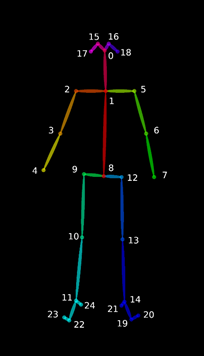 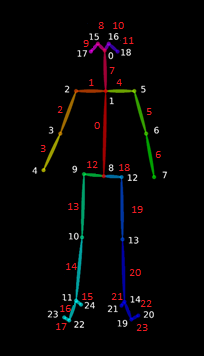 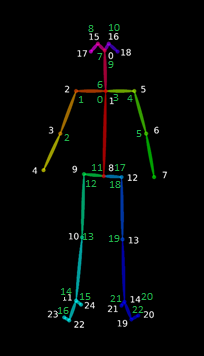


In [12]:
limbs = [(1,2),(2,3),(3,4),(1,5),(5,6),(6,7),(1,0),(0,15),(15,17),(0,16),(16,18),
           (8,9),(9,10),(10,11),(11,24),(11,23),(22,23),(8,12),(12,13),(13,14),
           (14,21),(14,19),(19,20)]

#direction - away from joint number 1 and then from down
angles = [(8,1,2),(1,2,3),(2,3,4),(8,1,5),(1,5,6),(5,6,7),(2,1,0),(1,0,15),(0,15,17),
          (1,0,16),(0,16,18),(1,8,9),(8,9,10),(9,10,11),(10,11,22),(10,11,24),(11,22,23),
          (1,8,12),(8,12,13),(12,13,14),(13,14,19),(13,14,21),(14,19,20)]

def calculate_angle(a, b, c):
  ba = a - b
  bc = c - b
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
  return (np.degrees(np.arccos(cosine_angle)) / 180)

def calculate_average_limb_lengths(x_coords):
  x_avg_lengths =[[] for i in range(24)]
  norms = []
  x_avg_lengths[0].append(1)
  for frame in x_coords:
    if (np.any(frame[1] == 0)) or (np.any(frame[8] == 0)):
      continue
    norm = np.linalg.norm(frame[1] - frame[8])
    norms.append(norm)
    l0 = 1
    for i, limb in enumerate(limbs):
      if (np.all(frame[limb[0]] != 0)) and (np.all(frame[limb[1]] != 0)):
        l = np.linalg.norm(frame[limb[0]] - frame[limb[1]]) / norm
        x_avg_lengths[i+1].append(l)

  limb_lengths_average = [sum(col)/len(col) for col in x_avg_lengths]
  norm_average = sum(norms)/len(norms)
  return limb_lengths_average, norm_average

def calculate_average_angles(x_coords):
  x_avg_angles =[[] for i in range(23)]
  for frame in x_coords:
    for i, angle in enumerate(angles):
      if (np.all(frame[angle[0]] != 0) and 
         np.all(frame[angle[1]] != 0) and 
         np.all(frame[angle[2]] != 0)):
        
        a = calculate_angle(frame[angle[0]],frame[angle[1]],frame[angle[2]])
        x_avg_angles[i].append(a)
  angles_average = [sum(col)/len(col) for col in x_avg_angles]
  return angles_average

def calculate_limb_lengths(x_coords, average_limbs, average_norm):
  x_lengths = []
  for frame in x_coords:
    x_person = []
    if (np.any(frame[1] == 0)) or (np.any(frame[8] == 0)):
      norm = average_norm
    else:
      norm = np.linalg.norm(frame[1] - frame[8])

    x_person.append(1)
    for i, limb in enumerate(limbs):
      if (np.any(frame[limb[0]] == 0)) or (np.any(frame[limb[1]] == 0)):
        l = average_limbs[i+1]
        x_person.append(l)
      else:
        l = np.linalg.norm(frame[limb[0]] - frame[limb[1]]) / norm
        x_person.append(l)

    x_lengths.append(x_person)
  return x_lengths

def calculate_angles(x_coords, average_ang):
  x_angles = []
  for frame in x_coords:
    x_person = []
    for i, angle in enumerate(angles):
      if (np.any(frame[angle[0]] == 0) or 
         np.any(frame[angle[1]] == 0) or 
         np.any(frame[angle[2]] == 0)):
        a = average_ang[i]
        x_person.append(a)
      else:
        a = calculate_angle(frame[angle[0]],frame[angle[1]],frame[angle[2]])
        x_person.append(a)
    x_angles.append(x_person)
  return x_angles

def calculate_distance(x_coords_1, x_coords_2, average_norm, distance_type = "2P"):
  x_distance = []
  for frame1, frame2 in zip(x_coords_1,x_coords_2):
    if (np.any(frame1[1] == 0)) or (np.any(frame1[8] == 0)):
        norm = average_norm
    else:
        norm = np.linalg.norm(frame1[1] - frame1[8])
    if (distance_type == "2P"):
      if (np.any(frame1[1] == 0)) or (np.any(frame2[1] == 0)):
        d = np.linalg.norm(frame1[0] - frame2[0]) / norm
        x_distance.append(d)
      else:
        d = np.linalg.norm(frame1[1] - frame2[1]) / norm
        x_distance.append(d)
    elif (distance_type == "25P"):
      x_person = []
      moving_avg_d = 1
      for i in range(25):
        if (np.any(frame1[i] == 0) or np.any(frame2[i] == 0)):
          moving_avg_d = (sum(x_person) + moving_avg_d) / (i + 1) 
          d = moving_avg_d
        else: 
          d = np.linalg.norm(frame1[i] - frame2[i]) / norm
        x_person.append(d)
      x_distance.append(x_person)
  return x_distance


In [13]:
def normalize(x, av_angles, av_norm, av_limbs, type = "P", distance = "2P"):
  #maybe add minmax scaling
  #removing c values
  x  = x.drop(x.columns[2::3], axis=1)
  #spliting data
  x_per1 = x.drop(x.columns[50:], axis=1)
  x_per2 = x.drop(x.columns[:50], axis=1)
  x_coords_per1 = []
  for x in x_per1.to_numpy():
    it = iter(x)
    joint_coords = list(zip(it,it))
    x_coords_per1.append(joint_coords)

  x_coords_per1 = np.array(x_coords_per1)

  x_coords_per2 = []
  for x in x_per2.to_numpy():
    it = iter(x)
    joint_coords = list(zip(it,it))
    x_coords_per2.append(joint_coords)

  x_coords_per2 = np.array(x_coords_per2)

  #Calculating new features
  x_angles_per1 = calculate_angles(x_coords_per1, av_angles)
  x_angles_per2 = calculate_angles(x_coords_per2, av_angles)
  x_limbs_per1 = calculate_limb_lengths(x_coords_per1,av_limbs, av_norm)
  x_limbs_per2 = calculate_limb_lengths(x_coords_per2,av_limbs, av_norm)
  x_distances = calculate_distance(x_coords_per1, x_coords_per2, av_norm, distance_type = distance)

  #Creating new dataframes
  x_angles_per1_df = pd.DataFrame(x_angles_per1)
  x_angles_per2_df = pd.DataFrame(x_angles_per2)
  x_limbs_per1_df = pd.DataFrame(x_limbs_per1)
  x_limbs_per2_df = pd.DataFrame(x_limbs_per2)
  x_distances_df = pd.DataFrame(x_distances)
  x_features_typeP = pd.concat([x_angles_per1_df, x_angles_per2_df, x_limbs_per1_df, x_limbs_per2_df, x_distances_df], axis=1)
  x_features_typeP.columns = range(0,x_features_typeP.shape[1])

  return x_features_typeP

Calculating average limbs and angles. These are used to fill missing values.

In [14]:
average_limbs, average_norm = calculate_average_limb_lengths(x_coords_per1)
average_angles = calculate_average_angles(x_coords_per1)

# Testing simple classifiers on yt videos

In [9]:
from IPython.display import YouTubeVideo
!pip install -q youtube-dl

def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

posses_dict= {1:"close up", 2:"get away from each other", 3:"kick",4:"push",
             5:"shake hands",6:"hug",7:"give a notebook",8:"punch"}

     |████████████████████████████████| 1.9MB 23.5MB/s 
ERROR: Operation cancelled by user


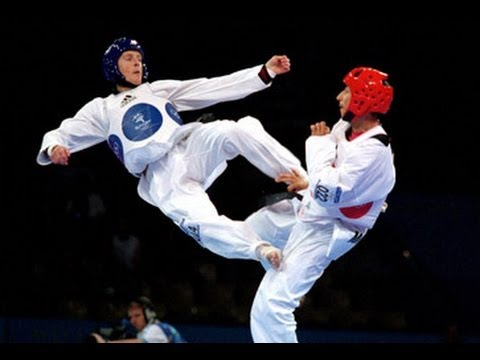

In [ ]:
YOUTUBE_ID = 'WPVuC6ugmAw'
YouTubeVideo(YOUTUBE_ID)

In [ ]:
!rm -rf youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# cut the video
!rm video.mp4
!ffmpeg -y -loglevel info -i youtube.mp4 -ss 00:0:14.0 -t 5 video.mp4
#resize to 640x480
!rm resized.mp4
!ffmpeg -i video.mp4 -s 640x480 -c:a copy resized.mp4
show_local_mp4_video("resized.mp4", width=640, height=480)

In [ ]:
#Using openpose
!rm -r /content/drive/My\ Drive/OpenPose/output 
!mkdir /content/drive/My\ Drive/OpenPose/output
!cd openpose && ./build/examples/openpose/openpose.bin --video ../resized.mp4 --write_json /content/drive/My\ Drive/OpenPose/output --display 0 --write_video /content/drive/My\ Drive/OpenPose/output/test.avi
#convert to mp4
!ffmpeg -y -loglevel info -i /content/drive/My\ Drive/OpenPose/output/test.avi /content/drive/My\ Drive/OpenPose/output/test.mp4
show_local_mp4_video("/content/drive/MyDrive/OpenPose/output/test.mp4", width=640, height=480)

In [ ]:
#load json
frame_data = pd.DataFrame()
pattern = re.compile("resized_.*_keypoints")
for dirpath, dirnames, filenames in os.walk("./drive/MyDrive/OpenPose/output", topdown=False):
  for file in sorted(filenames):
      if pattern.match(file):
          file_path = dirpath +'/'+ file
          with open(file_path) as f:
            loaded_json_dict = json.load(f)
          try:
            data = loaded_json_dict['people'][0]['pose_keypoints_2d'] + loaded_json_dict['people'][1]['pose_keypoints_2d']
            df = pd.DataFrame.transpose(pd.DataFrame.from_dict(data))
            frame_data = pd.concat([frame_data,df],ignore_index=True)
          except:
            data = loaded_json_dict['people'][0]['pose_keypoints_2d'] + 75*[0]
            df = pd.DataFrame.transpose(pd.DataFrame.from_dict(data))
            frame_data = pd.concat([frame_data,df],ignore_index=True)



## Load data

In [ ]:

full_data = pd.read_csv(r'./drive/MyDrive/OpenPose/full_data2.csv')

x = full_data.drop(["class", "batch"],axis=1)
y = full_data["class"].values

x_features_typeP = normalize(full_data, average_angles, average_norm, average_limbs, distance= "25P")

y = full_data["class"].values
x_train, x_test, y_train, y_test = train_test_split(x_features_typeP,y,test_size=0.25,shuffle=True)
normalized_data = normalize(frame_data, average_angles, average_norm, average_limbs, distance= "25P")

In [ ]:

accuracies = {}


class_val = np.full((len(frame_data)), 6)
knn_clf = KNeighborsClassifier(n_neighbors=3)
print('......')
svm_clf = SVC(random_state=1)
nb_clf = GaussianNB()
#nn_clf = MLPClassifier(solver='lbfgs',max_iter=20000)
sgd_clf = SGDClassifier()
rf_clf = RandomForestClassifier(n_estimators=100,random_state=1)

voting_clf = VotingClassifier(
        estimators=[('knn',knn_clf),('svm',svm_clf),('nb',nb_clf),
                    ('sgd',sgd_clf),('rf',rf_clf)], voting='hard')

from sklearn.metrics import accuracy_score
accuracies = {}
for clf in (knn_clf, svm_clf, nb_clf, sgd_clf, rf_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(normalized_data)
    p1 = np.count_nonzero(y_pred == 1)/ len(y_pred)
    p2 = np.count_nonzero(y_pred == 2)/ len(y_pred)
    p3 = np.count_nonzero(y_pred == 3)/ len(y_pred)
    p4 = np.count_nonzero(y_pred == 4)/ len(y_pred)
    p5 = np.count_nonzero(y_pred == 5)/ len(y_pred)
    p6 = np.count_nonzero(y_pred == 6)/ len(y_pred)
    p7 = np.count_nonzero(y_pred == 7)/ len(y_pred)
    p8 = np.count_nonzero(y_pred == 8)/ len(y_pred)
    preds = {p1:"close up", p2:"get away from each other", p3:"kick",p4:"push",
             p5:"shake hands",p6:"hug",p7:"give a notebook",p8:"punch"}
    print (preds)
    print(clf.__class__.__name__,accuracy_score(class_val, y_pred))
    accuracies[clf.__class__.__name__] = accuracy_score(class_val,y_pred)

print (accuracies)
y_pred = rf_clf.predict(normalized_data)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('./drive/MyDrive/OpenPose/output/test.mp4')

# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
frame_number=0
while(True):
  ret, frame = cap.read()
  frame_number = len(y_pred) if frame_number >= len(y_pred) else frame_number
  if ret == True: 
    cv2.putText(frame,  
                posses_dict[y_pred[frame_number]],  
                (50, 50),  
                cv2.FONT_HERSHEY_SIMPLEX, 1,  
                (0, 255, 255),  
                2,  
                cv2.LINE_4) 
    # Write the frame into the file 'output.avi'
    out.write(frame)
    frame_number+=1
    # Display the resulting frame    
    #cv2.imshow('frame',frame)

    # Press Q on keyboard to stop recording
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

  # Break the loop
  else:
    break  

# When everything done, release the video capture and video write objects
cap.release()
out.release()

# Closes all the frames
cv2.destroyAllWindows() 

#convert to mp4
!ffmpeg -y -loglevel info -i /content/outpy.avi  /content/outpy.mp4

show_local_mp4_video("/content/outpy.mp4", width=640, height=480)

# Single LSTM


## Imports

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn import preprocessing
import random
from collections import deque
from keras.utils import to_categorical

In [16]:
full_data = pd.read_csv(r'./drive/MyDrive/OpenPose/full_data2.csv')






In [67]:
train_size = 0.7
WINDOW_SIZE = 10 
#RATIO_TO_PREDICT = "LTC-USD"
EPOCHS = 15  # how many passes through our data
BATCH_SIZE = 32  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{WINDOW_SIZE}-SEQ-{int(time.time())}"

In [68]:
def preprocess_df(df, train_size, distance_type="25P"):

  time_step = df[["batch"]]
  x = full_data.drop(["class", "batch"],axis=1)
  y = df[["class"]]
  
  x_features_typeP = normalize(x , average_angles, average_norm, average_limbs, distance = distance_type)

  for col in x_features_typeP.columns:
    if col != "batch" and col != "class":
      x_features_typeP.dropna(inplace=True)
      #x_features_typeP[col] = preprocessing.scale(x_features_typeP[col].values)

  x_features_typeP = pd.concat([x_features_typeP, y, time_step], axis=1)
  train_indices = random.sample(range(int(max(time_step.values))), int(max(time_step.values) * train_size))
  full_data_train = x_features_typeP.loc[x_features_typeP['batch'].isin(train_indices)]
  full_data_test = x_features_typeP.loc[~x_features_typeP['batch'].isin(train_indices)]
  print(int(max(time_step.values) * train_size))

  
  x_train = full_data_train.drop(["class"],axis=1)
  x_test = full_data_test.drop(["class"],axis=1)
  y_train = full_data_train[["class"]]
  y_test = full_data_test[["class"]]
  
  return x_train, x_test, y_train, y_test


In [69]:
def create_sequences(x, y):

  df = pd.concat([x, y], axis=1)
  sequential_data = []
  prev_poses_data = deque(maxlen = WINDOW_SIZE)
  current_batch = 0
  #print (df)
  for i in df.values:
    prev_poses_data.append([n for n in i[:-2]])
    if current_batch == (i[-2]):
      if len(prev_poses_data) == WINDOW_SIZE:
        sequential_data.append([np.array(prev_poses_data), i[-1]])
    else:
      current_batch = (i[-2])
      prev_poses_data = deque(maxlen = WINDOW_SIZE)
      
      prev_poses_data.append([n for n in i[:-2]])

  X = []
  y = []

  for seq, label in sequential_data:
    X.append(seq)
    y.append(label)
  X = np.array(X)
  y = np.array(y).reshape(X.shape[0],1)
  return np.array(X), to_categorical(np.array(y))

  

# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = np.mean(scores), np.std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))



In [70]:
def build_LSTM_model(X_train_seq, X_test_seq, y_train_seq, y_test_seq):
  n_timesteps, n_features, n_outputs = X_train_seq.shape[1], X_train_seq.shape[2], y_train_seq.shape[1]

  model = Sequential()
  model.add(LSTM(128, input_shape=(n_timesteps,n_features), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(LSTM(128, return_sequences=True))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())

  model.add(LSTM(128))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(n_outputs, activation='softmax'))


  opt = Adam(lr=0.001, decay=1e-6)

  # Compile model
  model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
  )

  tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

  filepath = "RNN_Final-{epoch:02d}-{val_acc:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
  checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

  history = model.fit(
    X_train_seq, y_train_seq,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test_seq, y_test_seq),
    #callbacks=[tensorboard, checkpoint],
  )

  return model

  def evaluate_model(model, X_test_seq, y_test_seq):
    score = model.evaluate(X_test_seq, y_test_seq, verbose=1)
    return score[1]
    


In [ ]:



print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Save model
#model.save("models/{}".format(NAME))





In [72]:

scores = list()
repeats = 15
for r in range(repeats):
  X_train, X_test, y_train, y_test = preprocess_df(full_data, train_size=0.8)
  X_train_seq, y_train_seq = create_sequences(X_train, y_train)
  X_test_seq, y_test_seq = create_sequences(X_train, y_train)
  model = build_LSTM_model(X_train_seq, X_test_seq, y_train_seq, y_test_seq)
  _, score = model.evaluate(X_test_seq, y_test_seq, verbose=1)
  print('>#%d: %.3f' % (r+1, score))
  scores.append(score)
# summarize results
summarize_results(scores)

225
Epoch 1/15
108/108 [==============================] - 6s 24ms/step - loss: 1.4993 - accuracy: 0.4933 - val_loss: 1.8071 - val_accuracy: 0.3147
Epoch 2/15
108/108 [==============================] - 1s 12ms/step - loss: 0.6265 - accuracy: 0.8031 - val_loss: 3.1418 - val_accuracy: 0.2304
Epoch 3/15
108/108 [==============================] - 1s 13ms/step - loss: 0.4755 - accuracy: 0.8480 - val_loss: 1.5054 - val_accuracy: 0.6387
Epoch 4/15
108/108 [==============================] - 1s 13ms/step - loss: 0.3895 - accuracy: 0.8885 - val_loss: 1.6632 - val_accuracy: 0.4176
Epoch 5/15
108/108 [==============================] - 1s 13ms/step - loss: 0.3647 - accuracy: 0.8894 - val_loss: 2.0505 - val_accuracy: 0.5564
Epoch 6/15
108/108 [==============================] - 1s 13ms/step - loss: 0.3107 - accuracy: 0.9055 - val_loss: 2.0795 - val_accuracy: 0.5098
Epoch 7/15
108/108 [==============================] - 1s 13ms/step - loss: 0.2951 - accuracy: 0.9034 - val_loss: 1.8579 - val_accuracy: 0.

In [ ]:
a = model.predict(X_test_seq)

In [52]:
a[2]

array([0.07489849, 0.02227745, 0.09362051, 0.02644312, 0.2748052 ,
       0.1796496 , 0.01610574, 0.00666413, 0.30553582], dtype=float32)

In [51]:
y_test_seq[2]

array([0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [86]:
279 in train_indices

True

In [96]:
y_train

array([2, 2, 2, ..., 7, 7, 7])

In [ ]:
#jakie okna do 